In [1]:
from dataplotter import plot_residuals, plot_predictions, plot_results, plot_residual_dist
from load_data import LoadData
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# set seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [2]:
import pickle

def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

In [3]:
data = LoadData("master_data.xlsx").get_data()
# Rename cof column
data.drop(columns=['Unnamed: 0', 'lubricant', 'cof '], inplace=True)

In [4]:
df = data.copy()
scale_factor = 10000
df['swr'] = df['swr'] * scale_factor # scale up to get higher losses

In [5]:

# REMOVE OUTLIERS
import numpy as np
from scipy import stats

# Calculate z-scores for each column in the dataframe
z_scores = np.abs(stats.zscore(df))
# Define a threshold for z-score
threshold = 5
# Remove rows with z-scores above the threshold
df_noutliers = df[(z_scores < threshold).all(axis=1)]
print(f"Removed {len(df) - len(df_noutliers)} outliers")
df = df_noutliers
constant_columns = [col for col in df.columns if df[col].nunique() <= 1]
df.drop(columns=constant_columns, inplace=True)
print(f"Removed {len(constant_columns)} constant columns")

Removed 25 outliers
Removed 31 constant columns


In [6]:
import pandas as pd
import numpy as np

def StratifiedGroupShuffleSplit(df_main, group_id, category, train_size = 0.7):
    df_main = df_main.sample(frac=1, random_state=2).reset_index(drop=True)  # shuffle dataset

    # create empty train and test datasets
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()

    hparam_mse_wgt = 0.1  # must be between 0 and 1
    assert 0 <= hparam_mse_wgt <= 1
    train_proportion = train_size  # adjust train proportion to 70%
    assert 0 <= train_proportion <= 1

    total_records = len(df_main)
    train_target = int(total_records * train_proportion)
    test_target = total_records - train_target

    subject_grouped_df_main = df_main.groupby([group_id], sort=False, as_index=False)
    category_grouped_df_main = df_main.groupby(category).count()[[group_id]] / len(df_main) * 100

    def calc_mse_loss(df):
        grouped_df = df.groupby(category).count()[[group_id]] / len(df) * 100
        df_temp = category_grouped_df_main.join(grouped_df, on=category, how='left', lsuffix='_main')
        df_temp['diff'] = (df_temp[group_id + '_main'] - df_temp[group_id]) ** 2
        mse_loss = np.mean(df_temp['diff'])
        return mse_loss

    for _, group in subject_grouped_df_main:
        if len(df_train) < train_target:
            df_train = pd.concat([df_train, pd.DataFrame(group)], ignore_index=True)
        elif len(df_test) < test_target:
            df_test = pd.concat([df_test, pd.DataFrame(group)], ignore_index=True)
        else:
            mse_loss_diff_train = calc_mse_loss(df_train) - calc_mse_loss(pd.concat([df_train, pd.DataFrame(group)], ignore_index=True))
            mse_loss_diff_test = calc_mse_loss(df_test) - calc_mse_loss(pd.concat([df_test, pd.DataFrame(group)], ignore_index=True))

            total_records = len(df_train) + len(df_test)

            len_diff_train = train_proportion - (len(df_train) / total_records)
            len_diff_test = (1 - train_proportion) - (len(df_test) / total_records)

            len_loss_diff_train = len_diff_train * abs(len_diff_train)
            len_loss_diff_test = len_diff_test * abs(len_diff_test)

            loss_train = (hparam_mse_wgt * mse_loss_diff_train) + ((1 - hparam_mse_wgt) * len_loss_diff_train)
            loss_test = (hparam_mse_wgt * mse_loss_diff_test) + ((1 - hparam_mse_wgt) * len_loss_diff_test)

            if loss_train < loss_test:
                df_train = pd.concat([df_train, pd.DataFrame(group)], ignore_index=True)
            else:
                df_test = pd.concat([df_test, pd.DataFrame(group)], ignore_index=True)

    return df_train, df_test

# 'Group ID' is group identifier column, and 'steel type' is category column
df_train, df_test = StratifiedGroupShuffleSplit(df, 'Group ID', 'steel type')
print(f"Train: {len(df_train)} ({len(df_train) / len(df):.2%}) Test: {len(df_test)} ({len(df_test) / len(df):.2%})")


Train: 400 (69.93%) Test: 172 (30.07%)


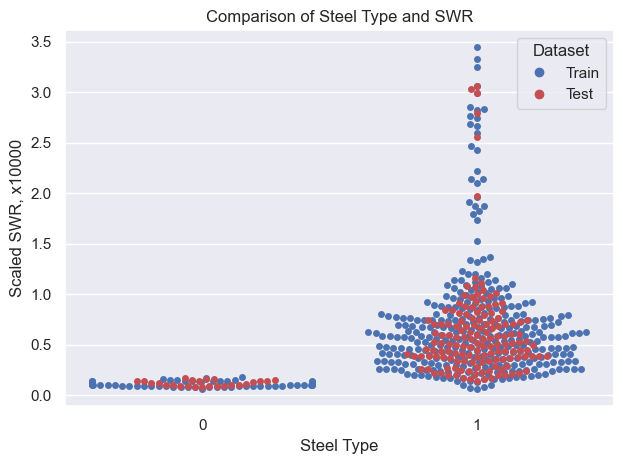

In [7]:
sns.set_theme(color_codes=True)
# Create a figure and axis
fig, ax = plt.subplots()

# Create the first swarm plot
sns.swarmplot(x='steel type', y='swr', data=df_train, color='b', ax=ax)

# Create the second swarm plot
sns.swarmplot(x='steel type', y='swr', data=df_test, color='r', ax=ax)

# Customize the plot
ax.set_title('Comparison of Steel Type and SWR')
ax.set_xlabel('Steel Type')
ax.set_ylabel('Scaled SWR, x10000')

# Add a custom legend
blue_patch = plt.Line2D([], [], marker='o', color='b', linestyle='None', label='Train')
red_patch = plt.Line2D([], [], marker='o', color='r', linestyle='None', label='Test')
ax.legend(handles=[blue_patch, red_patch], title='Dataset')
plt.tight_layout()

# Show the combined plot
plt.show()

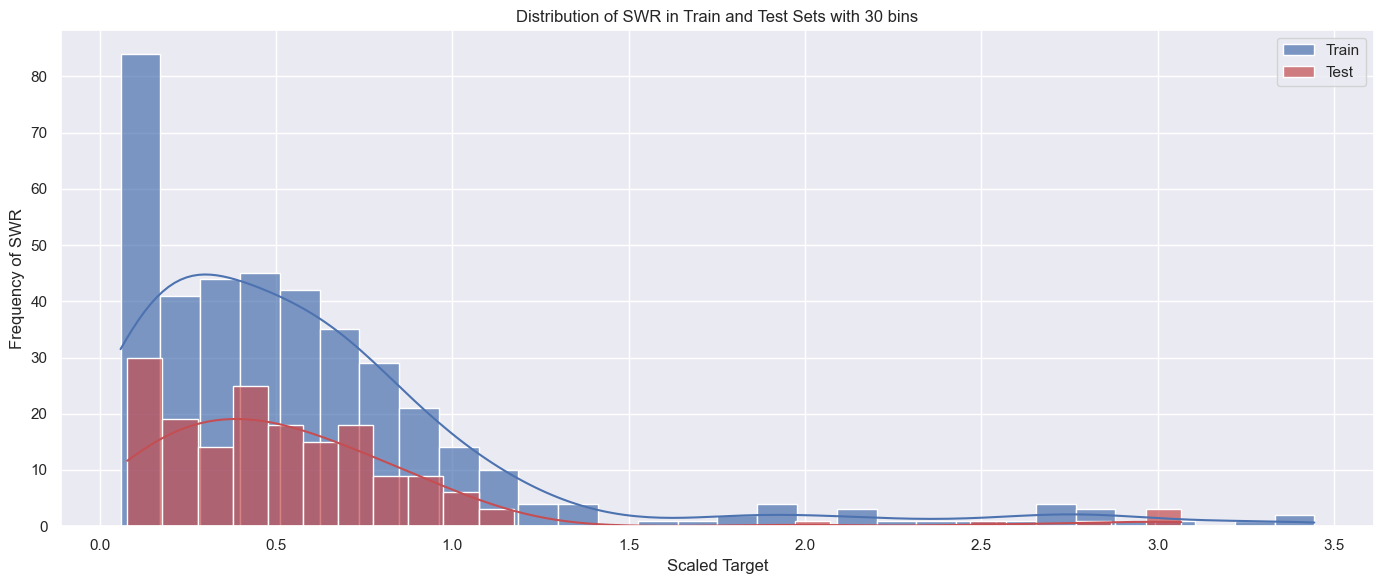

In [8]:
# Extract the target variable
train_target = df_train['swr']
test_target = df_test['swr']

# Plot the distribution of the target variable
plt.figure(figsize=(14, 6))
sns.set_theme(color_codes=True)
# Plot for training set
sns.histplot(train_target, kde=True, color='b', bins=30, alpha=0.7, label='Train')
# Plot for testing set
sns.histplot(test_target, kde=True, color='r', bins=30, alpha=0.7, label='Test')
plt.xlabel('Scaled Target')
plt.ylabel('Frequency of SWR')
plt.legend()
plt.title('Distribution of SWR in Train and Test Sets with 30 bins')
# Show the plot
plt.tight_layout()
plt.show()

In [9]:
train_df = df_train
test_df = df_test

In [10]:
from sklearn.feature_selection import VarianceThreshold

# Drop columns where the majority is zero valued
zero_cols = [col for col in train_df.columns if (train_df[col] == 0).sum() / len(train_df) > 0.5]
train_df.drop(columns=zero_cols, inplace=True)
test_df.drop(columns=zero_cols, inplace=True)

selector = VarianceThreshold(threshold=0.1)
selector.fit(train_df.drop('swr', axis=1))
keep_features = selector.get_support(indices=True)

filt_train_df = train_df.iloc[:, keep_features]
filt_test_df = test_df.iloc[:, keep_features]
# Make sure target is in df
filt_train_df['swr'] = train_df['swr']
filt_test_df['swr'] = test_df['swr']
train_df = filt_train_df
test_df = filt_test_df
print(f"Removed {len(df.columns) - len(train_df.columns)} features with low variance")
train_df['Group ID'] = df_train['Group ID']
test_df['Group ID'] = df_test['Group ID']

Removed 459 features with low variance


In [11]:
print(f"Size of full dataset: {len(df.columns)}")
print(f"number of zero columns: {len(zero_cols)}")
data.shape

Size of full dataset: 1012
number of zero columns: 317


(597, 1043)

In [12]:
# Function to remove multicollinearity with control over which feature to drop
def remove_multicollinearity(df, target='swr', threshold=0.9, important_features=['AMW', 'SHED_NL', 'MaxsOH',	'H%', 'IC2', 'B03[C-C]', 'B04[O-O]', 'steel type', 'CATS2D_05_AL']): #'AMW', 'SHED_NL', 'ZM1Kup', 'MaxsOH',	'Pol',	'H%', 'IC2', 'B03[C-C]', 'B04[O-O]', 'steel type',	'C%', 'CATS2D_05_AL'
    """
    Remove collinear features from the dataframe.
    
    Parameters:
    - df: DataFrame to process.
    - target: The target column name.
    - threshold: Correlation threshold above which to consider features collinear.
    
    Returns:
    - df_reduced: DataFrame with collinear features removed.
    - removed_features: List of removed features.
    """
    # Get the important features
    # Ensure target column is not considered in correlation checks
    features = df.drop(columns=[target])
    
    # Calculate the correlation matrix
    corr_matrix = features.corr().abs()
    
    # Select the upper triangle of the correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Initialize the set of columns to remove
    to_drop = set()
    
    # Iterate over the correlation matrix and determine which columns to drop
    for column in upper.columns:
        # Get pairs of features that are highly correlated
        highly_correlated_features = [index for index in upper.index if upper.at[index, column] > threshold]
        for feature in highly_correlated_features:
            # Drop the feature with the lower correlation with the target
            if column not in important_features and feature not in important_features:
                if df[target].corr(df[feature]) > df[target].corr(df[column]):
                    to_drop.add(column)
                else:
                    to_drop.add(feature)
            else:
                if column in important_features and feature in important_features:
                    print(f"Important features {feature} and {column} are correlated")
                    if df[target].corr(df[feature]) > df[target].corr(df[column]):
                        to_drop.add(column)
                        print(f"Dropped {column}")
                    else:
                        to_drop.add(feature)
                        print(f"Dropped {feature}")
                else:
                    if column in important_features:
                        to_drop.add(feature)
                    else:
                        to_drop.add(column)
    # Remove the identified features from the dataframe
    df_reduced = df.drop(columns=to_drop)
    return df_reduced, list(to_drop)
train_df_red, drop = remove_multicollinearity(train_df, target='swr', threshold=0.8)
print(f"Removed {len(drop)} collinear columns")
test_df_red = test_df.drop(columns=drop)

Important features CATS2D_05_AL and B04[O-O] are correlated
Dropped CATS2D_05_AL
Removed 534 collinear columns


In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.linear_model import (LinearRegression, Ridge, Lasso)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor



# Set up data for the model
X = train_df_red.drop(columns=['swr'], axis=1)
# Add a randomly generated feature
X['random_md'] = np.random.uniform(0,1) #np.random.normal(loc=0, scale=1, size=train_df_red.shape[0])
y = train_df_red['swr']
colnames = X.columns

#Scale data
scx = StandardScaler()
X_sc = scx.fit_transform(X)

# Define dictionary to store our rankings
ranks = {}
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

# Construct our Decision Tree model
lr = DecisionTreeRegressor()
lr.fit(X_sc, y)
#stop the search when only the last feature is left
rfe = RFE(lr, n_features_to_select=20, verbose=1 )
rfe.fit(X_sc, y)
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

# Using Linear Regression
lr = LinearRegression(positive=True, fit_intercept=True, n_jobs=-1)
lr.fit(X_sc, y)
ranks["LinReg"] = ranking(np.abs(lr.coef_), colnames)

# Using Ridge
ridge = Ridge(alpha = 1.0)
ridge.fit(X_sc, y)
ranks['Ridge'] = ranking(np.abs(ridge.coef_), colnames)

# Using Lasso
lasso = Lasso(alpha=0.02)
lasso.fit(X_sc, y)
ranks["Lasso"] = ranking(np.abs(lasso.coef_), colnames)

# Using RandomForest
rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, verbose=0)
rf.fit(X_sc, y)
ranks["RF"] = ranking(rf.feature_importances_, colnames)

# Create empty dictionary to store the mean value calculated from all the scores
r = {}
for name in colnames:
    r[name] = round(np.mean([ranks[method][name] for method in ranks.keys() if name in ranks[method]]), 2)

methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")

result_rankings = pd.DataFrame(ranks)


In [14]:
random_val = result_rankings.loc['random_md', 'Mean']
imp_feats = result_rankings[result_rankings['Mean'] > random_val].sort_values('Mean', ascending=False)
imp_feats=imp_feats.index.to_list()
# imp_feats += ['AMW', 'SHED_NL', 'ZM1Kup', 'MaxsOH',	'Pol',	'H%', 'IC2', 'B03[C-C]', 'B04[O-O]', 'steel type', 'C%', 'CATS2D_05_AL']
print(f"Keeping { len(imp_feats)} features")
print(f"Removed features: {', '.join([col for col in train_df_red.columns if col not in imp_feats and col != 'swr'])}")

Keeping 19 features
Removed features: 


In [15]:
train_df = train_df_red[imp_feats + ['swr']]
test_df = test_df_red[imp_feats + ['swr']]

In [16]:
import plotly.express as px
# Melt the DataFrame to long format
df_melted = train_df.drop(columns=['Group ID'], axis=1).melt(id_vars='swr', var_name='Feature', value_name='Value')

# Create the interactive plot
fig = px.scatter(df_melted, x='Value', y='swr', color='Feature',
                 title='Features vs swr', labels={'Value': 'Feature Values'},
                 width=1200, height=800)

# Update layout for better readability and add range slider and selector
fig.update_layout(
    legend=dict(title='Feature', traceorder='normal', itemsizing='constant', itemclick='toggleothers'),
    title_x=0.5,
    xaxis=dict(
        rangeslider=dict(visible=True),
        title='Feature Values',
        type='-'
    )
)

# Show the plot
fig.show()

In [17]:
# map all values in series to int
train_df.columns

Index(['AMW', 'MaxsOH', 'steel type', 'H-052', 'H%', 'GATS2i', 'Xindex',
       'MDEC-11', 's4_phRelSize_2', 'Group ID', 'B04[O-O]',
       's4_relPathLength_2', 'B03[C-C]', 'SHED_AN', 'SHED_NL', 'P_VSA_MR_7',
       'IC2', 'CATS2D_02_AN', 'chiralPhMoment', 'swr'],
      dtype='object')

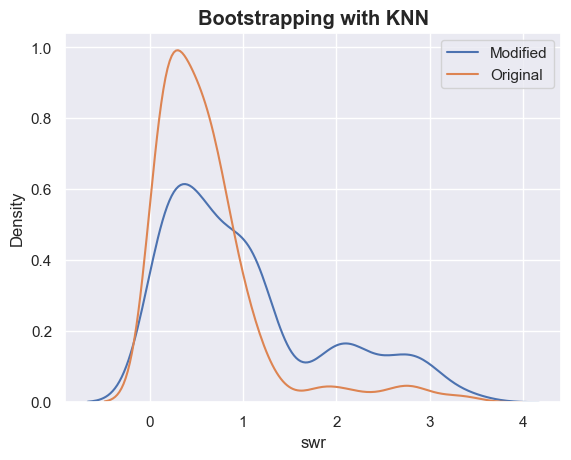

In [18]:
from Bootstrapping import bootstrap_sampling_with_knn, plot_resampling
train_X_bs_knn, train_y_bs_knn = bootstrap_sampling_with_knn(train_df.drop('swr', axis=1), train_df['swr'], n_samples=200, threshold=1, thresh_region="high")
plot_resampling(train_df['swr'], train_y_bs_knn, "Bootstrapping with KNN", path=r"C:\Users\58061\Documents\school\Master\Final\Plots\SWR\resample.png")

# kNN Bootstrapping

In [19]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Save path
path = r"./Plots/SWR/"
model_path = r"./Models2/SWR/"

train_X_df = train_X_bs_knn
train_y_df = train_y_bs_knn
test_X_df = test_df.drop(columns=['swr'])
test_y_df = test_df['swr']

# Remove non-scaling columns
no_scaling = ['steel type', 'Group ID']
train_X_df = train_X_df.drop(columns=no_scaling)
test_X_df = test_X_df.drop(columns=no_scaling)

scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_train = scaler_x.fit_transform(train_X_df)
X_test = scaler_x.transform(test_X_df)
y_train = scaler_y.fit_transform(train_y_df.values.reshape(-1, 1))
y_test = scaler_y.transform(test_y_df.values.reshape(-1, 1))

# Reshape the non-scaling column to be 2-dimensional
steel_type_train = train_X_bs_knn['steel type'].values.reshape(-1, 1)
steel_type_test = test_df['steel type'].values.reshape(-1, 1)

# Add back the non-scaling columns
X_train = np.hstack((X_train, steel_type_train))
X_test = np.hstack((X_test, steel_type_test))

print(X_train.shape)
print(X_test.shape)
# Save scaler
save_model(scaler_x, model_path + "scaler_x.pkl")
save_model(scaler_y, model_path + "scaler_y.pkl")


(600, 18)
(172, 18)


Train score
MSE:  1.0822633519383724e-09
MAE:  2.2218160877211854e-05
R2:  0.8545450762887885
Test score
MSE:  2.0353944753030075e-09
MAE:  3.188147340098061e-05
R2:  0.18340016279503102
LATEX: 
& 1.082e-09 & 2.222e-05 & 0.855 & & 2.035e-09 & 3.188e-05 & 0.183 \\


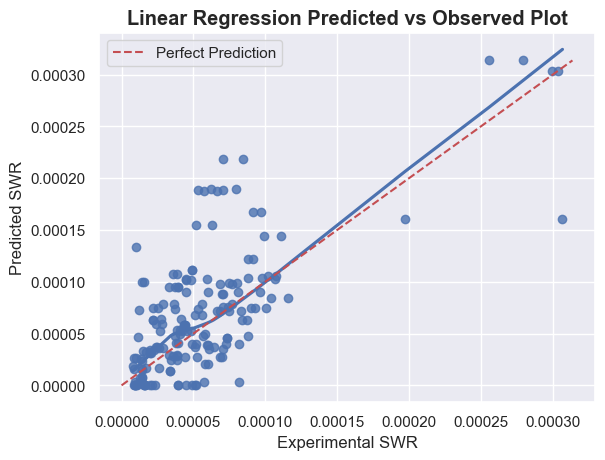

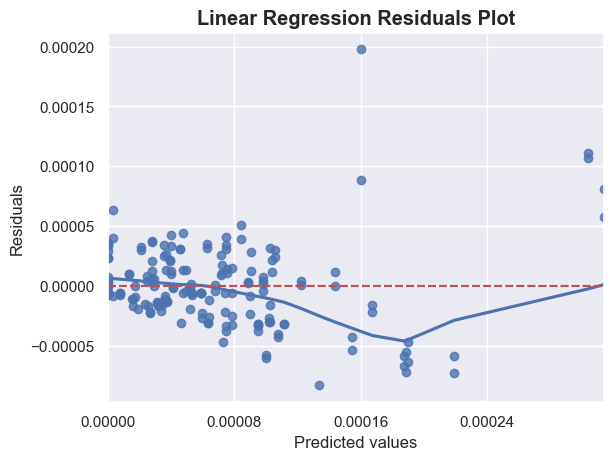

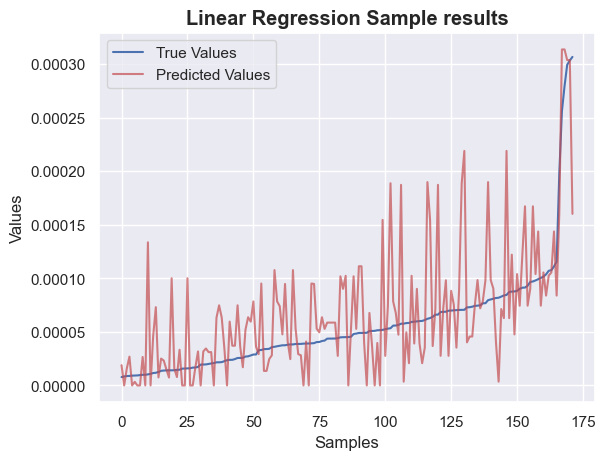

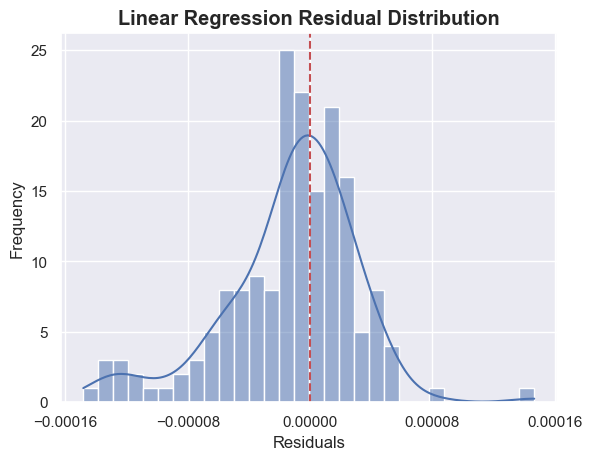

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

model = LinearRegression(positive=True, fit_intercept=True)
trans = PolynomialFeatures(degree=2)
pipe = Pipeline(steps=[('t', trans), ('m', model)])
pipe.fit(X_train, y_train)
y_train_org = scaler_y.inverse_transform(y_train)
y_test_org = scaler_y.inverse_transform(y_test)
print("Train score")
train_predictions = scaler_y.inverse_transform(pipe.predict(X_train))
train_predictions = np.clip(train_predictions, 0, None)
print("MSE: ", mean_squared_error(y_train_org/scale_factor, train_predictions/scale_factor))
print("MAE: ", mean_absolute_error(y_train_org/scale_factor, train_predictions/scale_factor))
print("R2: ", r2_score(y_train_org/scale_factor, train_predictions/scale_factor))

print("Test score")
predictions = scaler_y.inverse_transform(pipe.predict(X_test))
predictions = np.clip(predictions, 0, None)
print("MSE: ", mean_squared_error(y_test_org/scale_factor, predictions/scale_factor))
print("MAE: ", mean_absolute_error(y_test_org/scale_factor, predictions/scale_factor))
print("R2: ", r2_score(y_test_org/scale_factor, predictions/scale_factor))
print("LATEX: ")
print(f"& {mean_squared_error(y_train_org/scale_factor, train_predictions/scale_factor):.3e} & {mean_absolute_error(y_train_org/scale_factor, train_predictions/scale_factor):.3e} & {r2_score(y_train_org/scale_factor, train_predictions/scale_factor):.3f} & & {mean_squared_error(y_test_org/scale_factor, predictions/scale_factor):.3e} & {mean_absolute_error(y_test_org/scale_factor, predictions/scale_factor):.3e} & {r2_score(y_test_org/scale_factor, predictions/scale_factor):.3f} \\\\")


plot_predictions(y_test_org/scale_factor, predictions/scale_factor, "Linear Regression Predicted vs Observed Plot", path=path+"linreg_pred_vs_observed.png", target='SWR')
plot_residuals(y_test_org/scale_factor, predictions/scale_factor, "Linear Regression Residuals Plot", path=path+"linreg_residuals.png", showbins=5)
plot_results(y_test_org/scale_factor, predictions/scale_factor, "Linear Regression Sample results", path=path+"linreg_results.png")
plot_residual_dist(y_test_org/scale_factor, predictions/scale_factor, "Linear Regression Residual Distribution", path=path+"linreg_residual_dist.png", showbins=5)
save_model(pipe, model_path+"linreg_model.pkl")

Train score
MSE:  4.0238077447272287e-10
MAE:  1.1430087725983217e-05
R2:  0.9459204963847645
Test score
MSE:  1.0172449503700153e-09
MAE:  1.962269383981255e-05
R2:  0.5918815389601231
LATEX: 
& 4.024e-10 & 1.143e-05 & 0.946 & & 1.017e-09 & 1.962e-05 & 0.592 \\


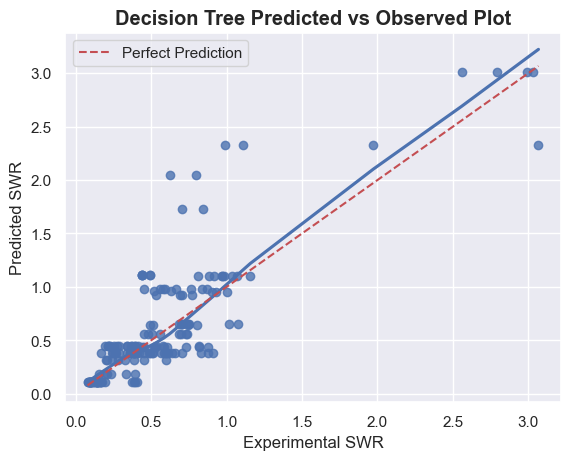

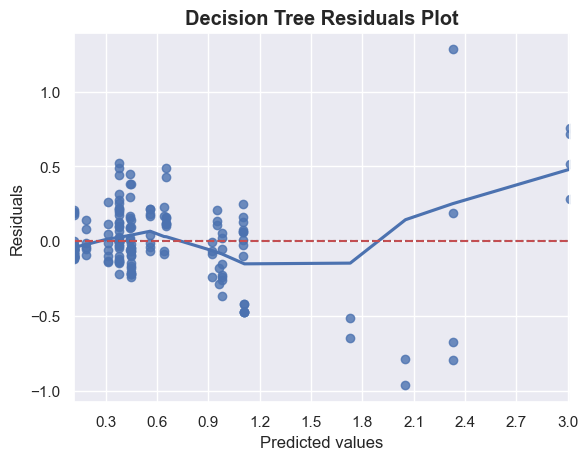

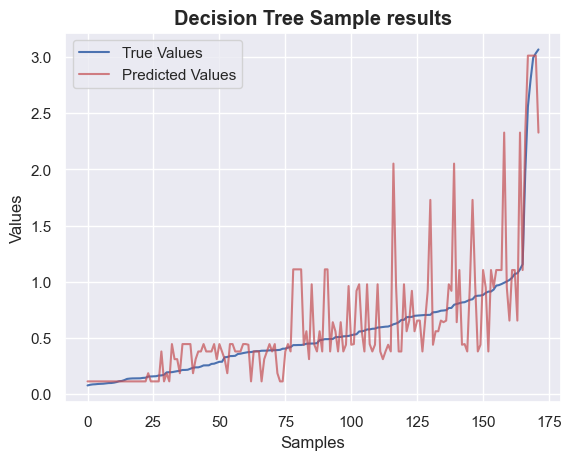

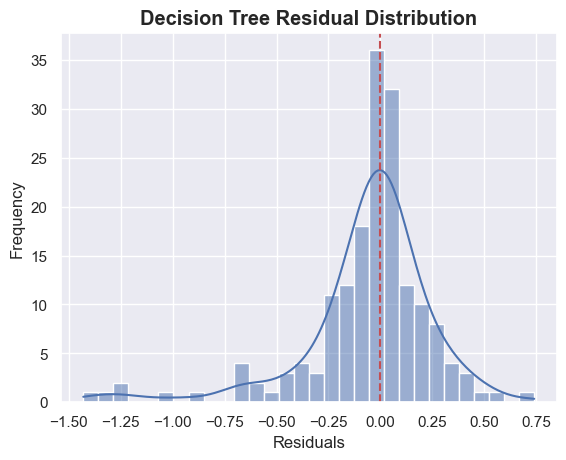

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

# Define the hyperparameters to tune
param_grid = {
    'max_depth': 10,  # The maximum depth of the tree
    'min_samples_split': 13, # The minimum number of samples required to split an internal node
    'min_samples_leaf': 6, # The minimum number of samples required to be at a leaf node
    'max_features': 'sqrt',  # To reduce the number of features to consider at each split
    'max_leaf_nodes': 30  # Limit the number of leaf nodes
}


model = DecisionTreeRegressor(random_state=42, **param_grid)
trans = PolynomialFeatures(degree=2)
pipe = Pipeline(steps=[('t', trans), ('m', model)])
pipe.fit(X_train, y_train)
y_train_org = scaler_y.inverse_transform(y_train)
y_test_org = scaler_y.inverse_transform(y_test)
print("Train score")
train_predictions = scaler_y.inverse_transform(pipe.predict(X_train).reshape(-1,1))
train_predictions = np.clip(train_predictions, 0, None)
print("MSE: ", mean_squared_error(y_train_org/scale_factor, train_predictions/scale_factor))
print("MAE: ", mean_absolute_error(y_train_org/scale_factor, train_predictions/scale_factor))
print("R2: ", r2_score(y_train_org/scale_factor, train_predictions/scale_factor))

print("Test score")
predictions = scaler_y.inverse_transform(pipe.predict(X_test).reshape(-1,1))
predictions = np.clip(predictions, 0, None)
print("MSE: ", mean_squared_error(y_test_org/scale_factor, predictions/scale_factor))
print("MAE: ", mean_absolute_error(y_test_org/scale_factor, predictions/scale_factor))
print("R2: ", r2_score(y_test_org/scale_factor, predictions/scale_factor))
print("LATEX: ")
print(f"& {mean_squared_error(y_train_org/scale_factor, train_predictions/scale_factor):.3e} & {mean_absolute_error(y_train_org/scale_factor, train_predictions/scale_factor):.3e} & {r2_score(y_train_org/scale_factor, train_predictions/scale_factor):.3f} & & {mean_squared_error(y_test_org/scale_factor, predictions/scale_factor):.3e} & {mean_absolute_error(y_test_org/scale_factor, predictions/scale_factor):.3e} & {r2_score(y_test_org/scale_factor, predictions/scale_factor):.3f} \\\\")


plot_predictions(y_test_org, predictions, "Decision Tree Predicted vs Observed Plot", path=path+"dtree_pred_vs_observed.png", target='SWR')
plot_residuals(y_test_org, predictions, "Decision Tree Residuals Plot", path=path+"dtree_residuals.png")
plot_results(y_test_org, predictions, "Decision Tree Sample results", path=path+"dtree_results.png")
plot_residual_dist(y_test_org, predictions, "Decision Tree Residual Distribution", path=path+"dtree_residual_dist.png")
save_model(pipe, model_path+"dtree_model.pkl")

[0]	eval-rmse:1.17667	train-rmse:1.10807
[1]	eval-rmse:1.16673	train-rmse:1.09807
[2]	eval-rmse:1.15784	train-rmse:1.08869
[3]	eval-rmse:1.14793	train-rmse:1.07884
[4]	eval-rmse:1.13882	train-rmse:1.06930
[5]	eval-rmse:1.13018	train-rmse:1.05954
[6]	eval-rmse:1.12069	train-rmse:1.04984
[7]	eval-rmse:1.11206	train-rmse:1.04055
[8]	eval-rmse:1.10320	train-rmse:1.03134
[9]	eval-rmse:1.09574	train-rmse:1.02242
[10]	eval-rmse:1.08821	train-rmse:1.01332
[11]	eval-rmse:1.07954	train-rmse:1.00429
[12]	eval-rmse:1.07077	train-rmse:0.99526
[13]	eval-rmse:1.06207	train-rmse:0.98684
[14]	eval-rmse:1.05443	train-rmse:0.97829
[15]	eval-rmse:1.04601	train-rmse:0.96958
[16]	eval-rmse:1.03858	train-rmse:0.96131
[17]	eval-rmse:1.03011	train-rmse:0.95291
[18]	eval-rmse:1.02257	train-rmse:0.94466
[19]	eval-rmse:1.01439	train-rmse:0.93644
[20]	eval-rmse:1.00776	train-rmse:0.92822
[21]	eval-rmse:0.99943	train-rmse:0.92000
[22]	eval-rmse:0.99086	train-rmse:0.91175
[23]	eval-rmse:0.98298	train-rmse:0.90371
[2

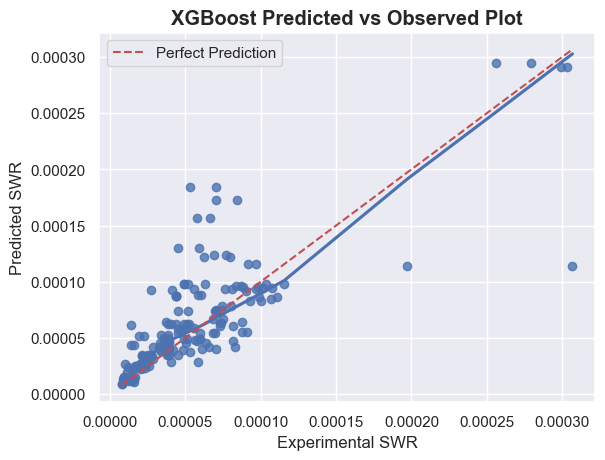

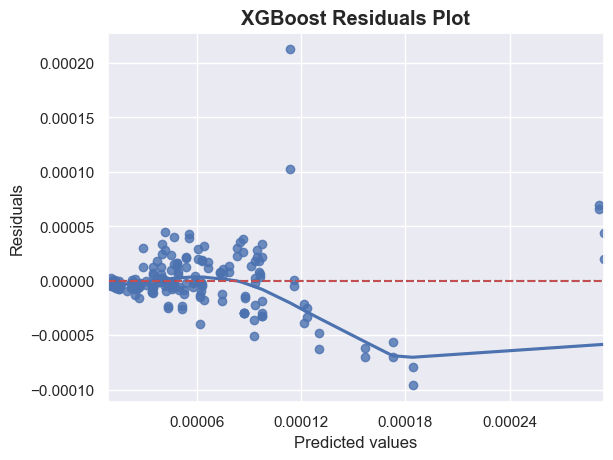

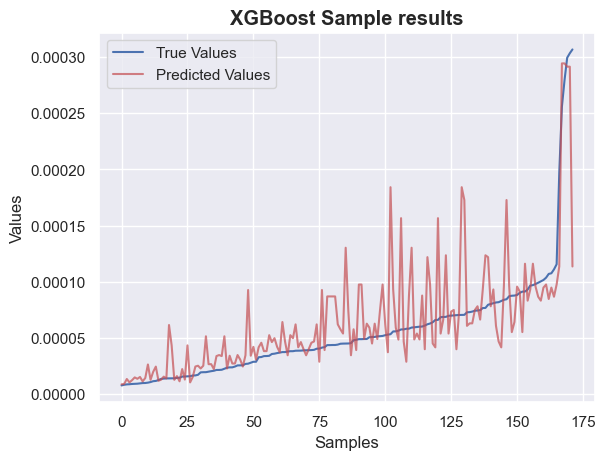

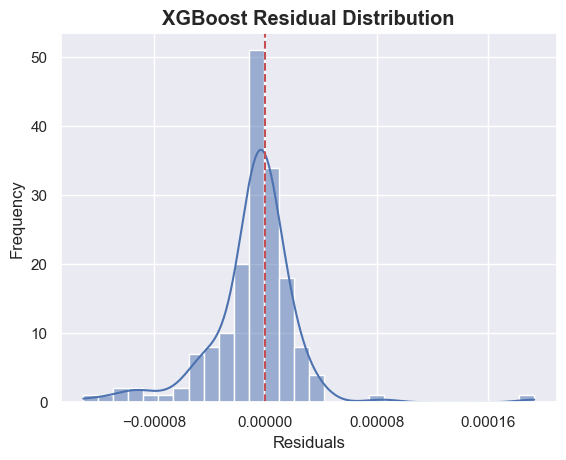

In [45]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

# Transform the features to polynomial features with degree 2
poly = PolynomialFeatures(degree=2, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train with the best parameters on the full training set
params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'learning_rate': 0.01,
    'subsample': 0.5,
    'colsample_bytree': 0.5,
    'gamma': 0.2,

}

# Creating DMatrix
dtrain = xgb.DMatrix(X_train_poly, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test_poly, label=y_test, enable_categorical=True)

# Training with early stopping
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 5000  # More rounds might be needed for regression
bst = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_round, evals=watchlist, early_stopping_rounds=20)

# Predictions and errors
train_preds = bst.predict(dtrain)
test_preds = bst.predict(dtest)

y_train_org = scaler_y.inverse_transform(y_train)
y_test_org = scaler_y.inverse_transform(y_test)
print("Train score")
train_predictions = scaler_y.inverse_transform(train_preds.reshape(-1, 1))
print("MSE: ", mean_squared_error(y_train_org/scale_factor, train_predictions/scale_factor))
print("MAE: ", mean_absolute_error(y_train_org/scale_factor, train_predictions/scale_factor))
print("R2: ", r2_score(y_train_org/scale_factor, train_predictions/scale_factor))

print("Test score")
predictions = scaler_y.inverse_transform(test_preds.reshape(-1, 1))
print("MSE: ", mean_squared_error(y_test_org/scale_factor, predictions/scale_factor))
print("MAE: ", mean_absolute_error(y_test_org/scale_factor, predictions/scale_factor))
print("R2: ", r2_score(y_test_org/scale_factor, predictions/scale_factor))

print("LATEX: ")
print(f"& {mean_squared_error(y_train_org/scale_factor, train_predictions/scale_factor):.3e} & {mean_absolute_error(y_train_org/scale_factor, train_predictions/scale_factor):.3e} & {r2_score(y_train_org/scale_factor, train_predictions/scale_factor):.3f} & & {mean_squared_error(y_test_org/scale_factor, predictions/scale_factor):.3e} & {mean_absolute_error(y_test_org/scale_factor, predictions/scale_factor):.3e} & {r2_score(y_test_org/scale_factor, predictions/scale_factor):.3f} \\\\")

# Plot functions (assuming they are defined elsewhere)
plot_predictions(y_test_org/scale_factor, predictions/scale_factor, "XGBoost Predicted vs Observed Plot", path=path+"xgboost_pred_vs_observed.png", target='SWR')
plot_residuals(y_test_org/scale_factor, predictions/scale_factor, "XGBoost Residuals Plot", path=path+"xgboost_residuals.png", showbins=5)
plot_results(y_test_org/scale_factor, predictions/scale_factor, "XGBoost Sample results", path=path+"xgboost_results.png")
plot_residual_dist(y_test_org/scale_factor, predictions/scale_factor, "XGBoost Residual Distribution", path=path+"xgboost_residual_dist.png", showbins=5)
save_model(bst, model_path+"xgboost_model.pkl")
